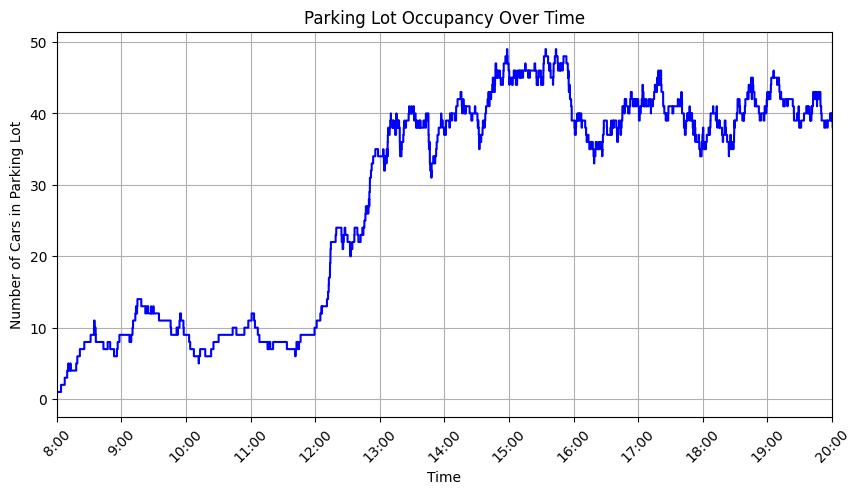

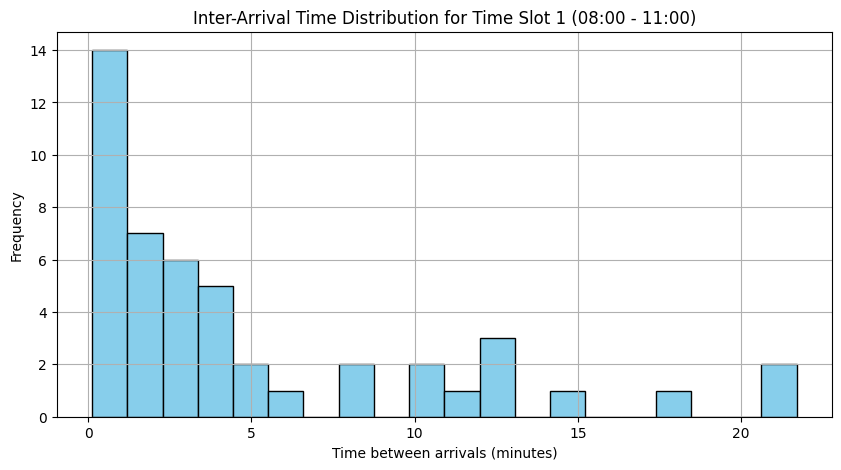

Average inter-arrival time for slot 47: 5.06 minutes


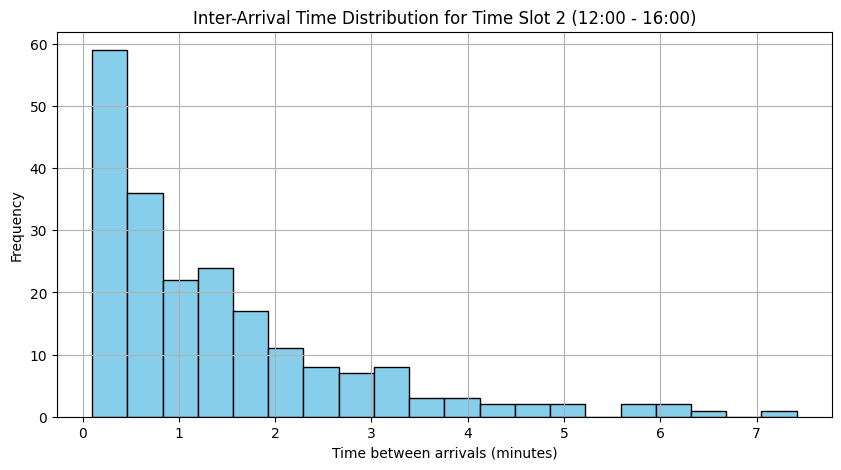

Average inter-arrival time for slot 210: 1.43 minutes


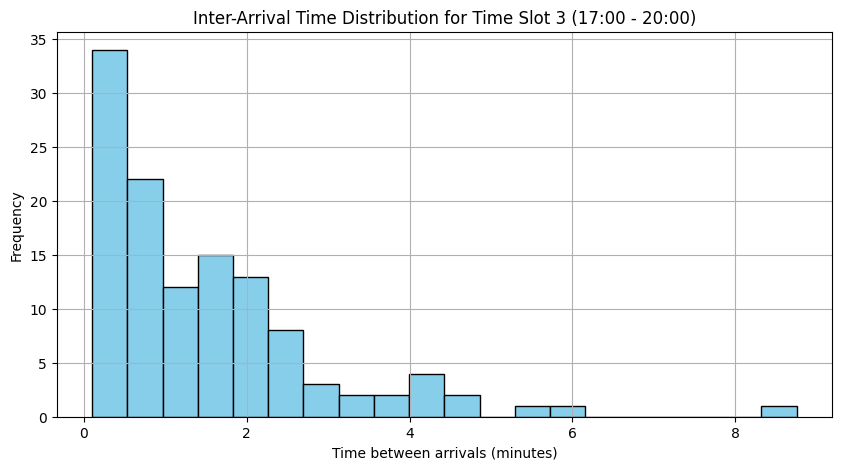

Average inter-arrival time for slot 120: 1.49 minutes


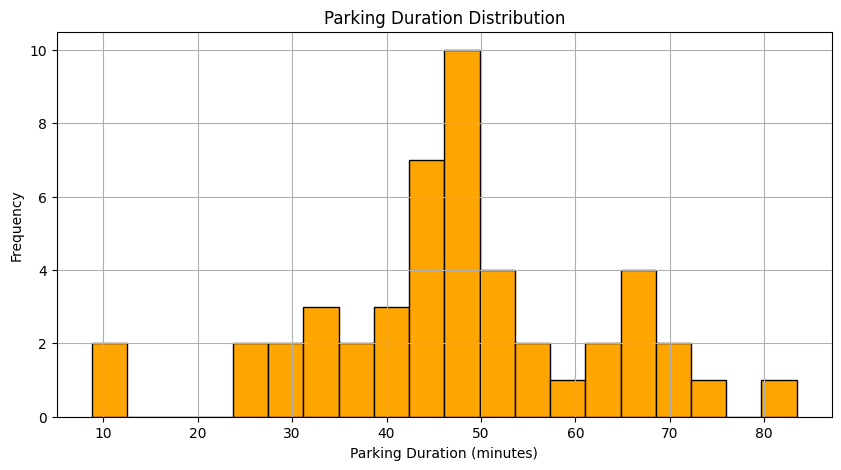

Number of lost customers: 0


In [25]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# Define arrival rates for specific time slots (in cars per minute)
time_slots = [
    (8 * 60, 11 * 60 + 59, 15 / 60),   # 08:00 - 11:59 (15 cars/hour)
    (12 * 60, 16 * 60 + 59, 50 / 60),  # 12:00 - 16:59 (50 cars/hour)
    (17 * 60, 20 * 60, 50 / 60)        # 17:00 - 20:00 (50 cars/hour)
]

# Define simulation parameters
PARKING_SPACES = 100          # Number of parking spaces in the lot
SIMULATION_TIME = 12 * 60 * 60  # Simulation time for 12 hours
PARKING_DURATION_MEAN = 59     # Average time a car spends parked (in minutes)

# Data storage
arrival_times = {i: [] for i in range(len(time_slots))}
departure_times = []
lost_customers = 0
parking_lot_occupancy = []

# Factors for adjusting lambda based on weather and price
base_wtv = 80                 # Base WTV (neutral)
price_sensitivity = -1.27      # Sensitivity of WTV to price changes (negative: higher price worsens WTV)
base_price = 25               # Base parking price
current_price = 35            # Current price (can adjust to simulate different scenarios)

def calculate_wtv(current_price):
    """Calculate WTV based on the current price and sensitivity."""
    return base_wtv + price_sensitivity * (current_price - base_price)

def adjust_lambda(base_lambda, wtv):
    """Adjust base lambda using the calculated WTV."""
    return base_lambda * (wtv / base_wtv)

def get_current_lambda(current_minute):
    """Determine the current lambda based on the simulated time and adjust with weather factors."""
    wtv = calculate_wtv(current_price)  # Calculate current WTV based on price
    for i, (start, end, rate) in enumerate(time_slots):
        if start <= current_minute <= end:
            adjusted_rate = adjust_lambda(rate, wtv)
            return adjusted_rate, i
    return 0, -1  # If outside defined time slots, assume no arrivals

def car(env, parking_lot, name, slot):
    global lost_customers
    arrival_time = env.now
    if len(parking_lot.queue) + parking_lot.count < PARKING_SPACES:
        arrival_times[slot].append(arrival_time)
        with parking_lot.request() as request:
            yield request
            # Record parking lot occupancy before and after parking
            parking_lot_occupancy.append((env.now, parking_lot.count))
            parking_duration = np.random.exponential(PARKING_DURATION_MEAN)
            yield env.timeout(parking_duration)
            departure_time = env.now
            departure_times.append(departure_time)
            parking_lot_occupancy.append((env.now, parking_lot.count - 1))
    else:
        lost_customers += 1

def car_generator(env, parking_lot):
    """Generate cars based on the time slots and arrival rates."""
    while env.now < SIMULATION_TIME:
        current_lambda, slot = get_current_lambda(env.now)
        if current_lambda > 0:
            inter_arrival_time = np.random.exponential(1 / current_lambda)
            inter_arrival_time = max(inter_arrival_time, 0.1)  # Avoid generating cars too fast
            yield env.timeout(inter_arrival_time)
            env.process(car(env, parking_lot, f'Car at time {env.now}', slot))
        else:
            yield env.timeout(1)  # Skip time where no cars should arrive

# Set up the environment and the parking lot resource
env = simpy.Environment()
parking_lot = simpy.Resource(env, capacity=PARKING_SPACES)

# Start the car arrival process
env.process(car_generator(env, parking_lot))

# Run the simulation
env.run(until=SIMULATION_TIME)  # Run for the defined simulation time

# Convert minutes to time labels for x-axis
times, occupancy = zip(*parking_lot_occupancy)
time_labels = [f'{int(t) // 60 + 8:02d}:00' for t in times]  # Convert minutes since 8:00 to HH:00 format

# Plot the parking lot occupancy over time
plt.figure(figsize=(10, 5))
plt.step(times, occupancy, where='post', color='blue')
plt.title('Parking Lot Occupancy Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Cars in Parking Lot')
plt.xlim(8 * 60, 20 * 60)  # Set x-axis limits from 8:00 AM to 8:00 PM
plt.xticks(np.arange(8 * 60, 20 * 60 + 1, 60), labels=[f'{h}:00' for h in range(8, 21)], rotation=45)
plt.grid(True)
plt.show()

# Plot inter-arrival times for each time slot
for i, (start, end, rate) in enumerate(time_slots):
    if len(arrival_times[i]) > 1:
        inter_arrival_times = [arrival_times[i][j] - arrival_times[i][j-1] for j in range(1, len(arrival_times[i]))]
        plt.figure(figsize=(10, 5))
        plt.hist(inter_arrival_times, bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Inter-Arrival Time Distribution for Time Slot {i+1} ({start//60:02d}:00 - {end//60:02d}:00)')
        plt.xlabel('Time between arrivals (minutes)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        
        # Print the inter-arrival time between the cars and average inter-arrival time
        count = 0
        sum_inter_arrival = 0
        for i, time in enumerate(inter_arrival_times, start=1):
            count += 1
            sum_inter_arrival += time
        avg_inter_arrival = sum_inter_arrival / count if count > 0 else 0
        print(f"Average inter-arrival time for slot {i}: {avg_inter_arrival:.2f} minutes")

# Calculate and plot parking durations
if len(departure_times) > 0 and len(arrival_times[0]) > 0:
    min_length = min(len(arrival_times[0]), len(departure_times))
    parking_durations = [departure_times[i] - arrival_times[0][i] for i in range(min_length)]
    plt.figure(figsize=(10, 5))
    plt.hist(parking_durations, bins=20, color='orange', edgecolor='black')
    plt.title('Parking Duration Distribution')
    plt.xlabel('Parking Duration (minutes)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Print the number of lost customers
print(f'Number of lost customers: {lost_customers}')
